In [1]:
import numpy as np
import pandas as pd
import astroquery
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
from numpy.random import poisson, beta, uniform

import occSimFuncs as occFunc
from tvguide import TessPointing

from astropy.coordinates import SkyCoord
from astropy import units as u

%matplotlib inline

In [2]:
msun = 1.9891E30
rsun = 695500000.
G = 6.67384E-11
AU = 149597870700.

consts = {'sigma_threshold': 7.3}

In [3]:
def make_allplanets_df_vec(df,starid_zp):
    # lets refector the above code to make it array operations
    totalRows = df.loc[:, 'Nplanets'].sum()

    df.loc[:, 'planetRadius'] = pd.Series()
    df.loc[:, 'planetPeriod'] = pd.Series()
    df.loc[:, 'starID'] = pd.Series()

    radper_dressing = occFunc.Dressing15_select(totalRows)
    radper_fressin = occFunc.Fressin13_select(totalRows)

    #we need an array of indices
    totalRows = df.loc[:, 'Nplanets'].sum()
    rowIdx = np.repeat(np.arange(df.shape[0]),np.array(df.Nplanets.values))

    newdf = df.iloc[rowIdx]
    newdf.loc[:, 'starID'] = rowIdx + starid_zp


    newdf.loc[:,'planetRadius'] = np.where(newdf.isMdwarf,radper_dressing[0],radper_fressin[0])
    newdf.loc[:,'planetPeriod'] = np.where(newdf.isMdwarf,radper_dressing[1],radper_fressin[1])
    newdf.set_index(np.arange(newdf.shape[0]), inplace=True)

    return newdf, newdf.starID.iloc[-1]

We are going to load real stars from the TIC and put planets around these and see how many we can detect

In [4]:
def component_noise(tessmag, readmod=1, zodimod=1):
    sys = 59.785
    star_mag_level, star_noise_level = np.array([
        [4.3885191347753745, 12.090570910640581],
        [12.023294509151416, 467.96434635620614],
        [17.753743760399338, 7779.603209291808]]).T
    star_pars = np.polyfit(star_mag_level, np.log10(star_noise_level), 1)
    zodi_mag_level, zodi_noise_level = np.array([
        [8.686356073211314, 18.112513551189224],
        [13.08901830282862, 688.2812796087189],
        [16.68801996672213, 19493.670323892282]]).T
    zodi_pars = np.polyfit(zodi_mag_level, np.log10(zodi_noise_level), 1)
    read_mag_level, read_noise_level = np.array([
        [8.476705490848586, 12.31474807751376],
        [13.019134775374376, 522.4985702369348],
        [17.841098169717142, 46226.777232915076]]).T
    read_pars = np.polyfit(read_mag_level, np.log10(read_noise_level), 1)
    
    c1, c2, c3, c4 = (10 ** (tessmag * star_pars[0] + star_pars[1]), 
                      10 ** (tessmag * zodi_pars[0] + zodi_pars[1]),
                      10 ** (tessmag * read_pars[0] + read_pars[1]), sys)
    
    return np.sqrt(c1**2 + (readmod*c2)**2 + (zodimod*c3)**2 + c4**2)

In [5]:
# load the targets
fn = '../data/selectedreal5.csv.bz2'
df = pd.read_csv(fn)

In [6]:
# some things we are going to need later
df['isMdwarf'] = np.where((df.TEFF < 3900) & (df.RADIUS < 0.5), True, False)
df['isGiant'] = np.ones(df.shape[0], dtype='bool') # assume all dwarfs

# df['tess_ccd'] = np.zeros(df.shape[0], dtype='int') 
# df['tess_ccd'] = np.where((np.abs(df.ECLAT) >= 6) & (np.abs(df.ECLAT) < 30), 
#                           1, df.tess_ccd)
# df['tess_ccd'] = np.where((np.abs(df.ECLAT) >= 30) & (np.abs(df.ECLAT) < 54), 
#                           2, df.tess_ccd)
# df['tess_ccd'] = np.where((np.abs(df.ECLAT) >= 54) & (np.abs(df.ECLAT) < 78), 
#                           3, df.tess_ccd)
# df['tess_ccd'] = np.where((np.abs(df.ECLAT) >= 78) & (np.abs(df.ECLAT) < 90), 
#                           4, df.tess_ccd) # spins on axis

# # there are some dodgy assumptions here, which we can fix later
# # we probably want to use tvguide
# df['obs_len'] = np.zeros(df.shape[0], dtype='float') 
# df['obs_len'] =  np.where(df.tess_ccd == 1, 27.4, df.obs_len)
# df['obs_len'] =  np.where(df.tess_ccd == 4, 27.4*13., df.obs_len)

# # ccd 2 and 3 are harder, we are going to do something stupid and wrong for now
# df['obs_len'] =  np.where(df.tess_ccd == 2, 27.4, df.obs_len)
# df['obs_len'] =  np.where(df.tess_ccd == 2, 27.4*2, df.obs_len)

# this cosi will be the same for every planet in the system
df['cosi'] = pd.Series(np.random.random(size=df.shape[0]),name='cosi')

df['noise_level'] = component_noise(df.TESSMAG, readmod=1, zodimod=1)

In [7]:
df['tess_ccd'] = np.zeros(df.shape[0], dtype='int')
df['obs_len'] = np.zeros(df.shape[0], dtype='float') 
for i in tqdm(df.index):
    #need a hack to force stars in the northern hemisphere to work
    if df.loc[i,'ECLAT'] >= 6:
        gc = SkyCoord(lon=df.loc[i,'ECLONG'] * u.degree, lat=df.loc[i, 'ECLAT'] * u.degree * -1,
                      frame='barycentrictrueecliptic')
        obj = TessPointing(gc.icrs.ra.value, gc.icrs.dec.value)
    else:
        obj = TessPointing(df.loc[i,'RA'], df.loc[i,'DEC'])
    df.loc[i,'tess_ccd'] = obj.get_camera()
    df.loc[i,'obs_len'] = obj.get_13cameras()[obj.get_13cameras() > 0].shape[0] * 27.4

100%|██████████| 222000/222000 [3:25:52<00:00,  8.89it/s]  


In [8]:
print('total stars = {}'.format(df[df.tess_ccd > 0].shape[0]))
print('total target slots = {}'.format(np.sum(df.obs_len) / 27.4))

total stars = 205769
total target slots = 436873.00000130705


In [9]:
# how many planets should each star get
np_fgk = poisson(lam=0.689,size=df.shape[0])
np_m = poisson(lam=2.5,size=df.shape[0])
df['Nplanets'] = pd.Series(np.where(df.isMdwarf, np_m, np_fgk), name='Nplanets')

In [10]:
# draw a bunch of planest and accociate them with each star
starID = 0 # ???
newDF, starID = make_allplanets_df_vec(df, starID)

# get some transit epochs
newDF = newDF.assign(T0=pd.Series(uniform(0, 1, size=newDF.shape[0]) * newDF.loc[:, 'planetPeriod']))

#calculate the number of transits
nt1 = np.floor(newDF['obs_len'] / newDF.planetPeriod)
newDF['Ntransits'] = np.where(newDF['T0'] < newDF['obs_len'] % newDF.planetPeriod, nt1+1,nt1)
newDF['ars'] = occFunc.per2ars(newDF.planetPeriod, newDF.MASS, newDF.RADIUS)
newDF['ecc'] = pd.Series(beta(1.03,13.6,size=newDF.shape[0]),name='ecc', ) # ecc dist from Van Eylen 2015
newDF['omega'] = pd.Series(uniform(-np.pi,np.pi,size=newDF.shape[0]),name='omega')
newDF['rprs'] = occFunc.get_rprs(newDF.planetRadius, newDF.RADIUS)
newDF['impact'] = newDF.cosi * newDF.ars * ((1-newDF.ecc**2)/1+newDF.ecc*np.sin(newDF.omega)) # cite Winn
newDF['duration'] = occFunc.get_duration(newDF.planetPeriod, newDF.ars, cosi=newDF.cosi, b=newDF.impact,
                                rprs=newDF.rprs) # cite Winn
newDF['duration_correction'] = np.sqrt(newDF.duration * 24.) # correction for CDPP because transit dur != 1 hour
newDF['transit_depth']  = occFunc.get_transit_depth(newDF.planetRadius, newDF.RADIUS)

newDF['transit_depth_diluted']  = newDF['transit_depth'] / (1+newDF.CONTRATIO)

/Users/tom/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/tom/gitcode/tyieldsim/code/occSimFuncs.py:27: RuntimeWarning: invalid value encountered in sqrt
  part3 = np.sqrt((1 + rprs)**2 - b**2)
/Users/tom/gitcode/tyieldsim/code/occSimFuncs.py:29: RuntimeWarning: invalid value encountered in arcsin
  duration = part1 * np.arcsin(part2 * part3 / part4)


In [11]:
# now lets see if those planets are detected
newDF['needed_for_detection'] = (newDF.transit_depth_diluted * newDF.duration_correction *
                    np.sqrt(newDF.Ntransits)) / consts['sigma_threshold']

newDF['has_transits']  = (newDF.ars > 1.0) & (newDF.impact < 1.0)

In [12]:
newDF['detected'] = (newDF.noise_level < newDF.needed_for_detection) & (newDF.Ntransits >= 3) & (newDF.planetRadius > 0.0) & newDF.has_transits


total_planets = newDF.detected.sum()

In [13]:
total_planets

949

In [14]:
detected_DF = newDF[newDF.detected == True]

(array([   6.,  299.,  316.,  229.,   15.,   17.,   10.,    8.,    7.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

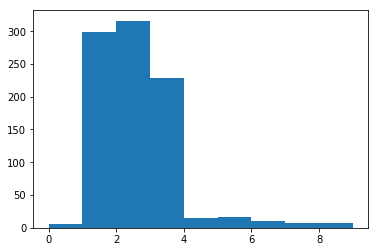

In [15]:
plt.hist(detected_DF.planetRadius, bins=np.arange(0,10,1))

(array([ 717.,  144.,   43.,   15.,    8.,    4.,    8.,    2.,    7.,    0.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100]),
 <a list of 10 Patch objects>)

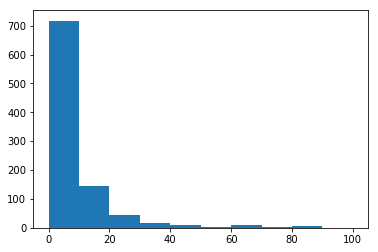

In [16]:
plt.hist(detected_DF.planetPeriod, np.arange(0,110,10))

(array([   0.,   52.,  130.,  135.,  105.,   39.,   42.,   54.,   73.,
          62.,   69.,   53.,   37.,   29.,   23.,   19.,    7.,    4.,
           4.,    0.,    2.,    0.,    2.,    1.,    0.,    0.,    1.,
           0.,    0.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
         1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
         2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9]),
 <a list of 29 Patch objects>)

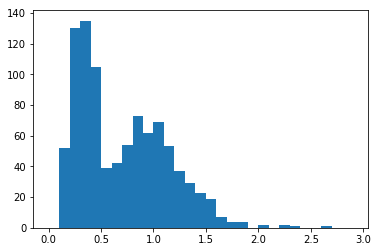

In [17]:
plt.hist(detected_DF.RADIUS, np.arange(0,3,0.1))

(array([ 1515.,   766.,   701.,   552.,   484.,   385.,   315.,   276.,
          240.,   206.,   168.,   153.,   128.,    89.,   105.,    98.,
           73.,    74.,    77.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5]),
 <a list of 19 Patch objects>)

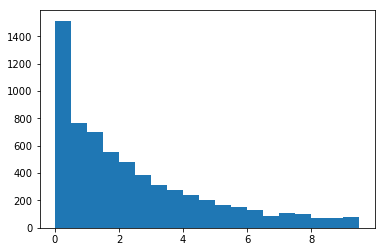

In [18]:
q = (newDF.transit_depth_diluted * newDF.duration_correction *
                    np.sqrt(newDF.Ntransits)) / newDF.noise_level

plt.hist(q[np.isfinite(q)]  , np.arange(0,10,0.5))

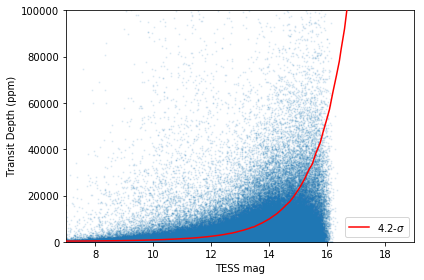

In [19]:
mag_level, noise_level = np.genfromtxt('TessNoise_1h_v2.csv', delimiter=',',
                                           unpack=True,
                                           comments='#')

plt.scatter(newDF.TESSMAG, newDF.transit_depth_diluted * np.sqrt(newDF.obs_len / newDF.planetPeriod),  
            s=1, alpha=0.1)
plt.plot(mag_level, noise_level * 4.2, zorder=100, color='r', label='4.2-$\sigma$')
plt.ylim(0,100000)
plt.xlim(7,19)
plt.xlabel('TESS mag')
plt.ylabel('Transit Depth (ppm)')
plt.legend()
plt.tight_layout()
plt.savefig('transitnoise.png', dpi=150)


(array([  3798.,   6493.,    368.,    732.,   1218.,   2182.,   3577.,
          5479.,   7768.,  10693.,  13368.,  14462.,  15150.,  17076.,
         23534.,  34626.,  45118.,  45526.,  36565.,  25694.,  16586.,
          6809.,    344.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.]),
 array([  5. ,   5.5,   6. ,   6.5,   7. ,   7.5,   8. ,   8.5,   9. ,
          9.5,  10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,  13.5,
         14. ,  14.5,  15. ,  15.5,  16. ,  16.5,  17. ,  17.5,  18. ,
         18.5,  19. ,  19.5,  20. ,  20.5]),
 <a list of 31 Patch objects>)

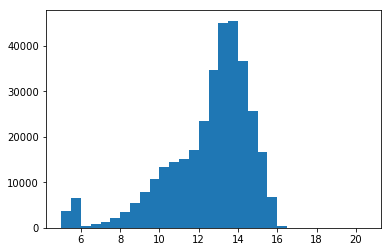

In [20]:
plt.hist(newDF.TESSMAG, bins=np.arange(5,21,0.5))

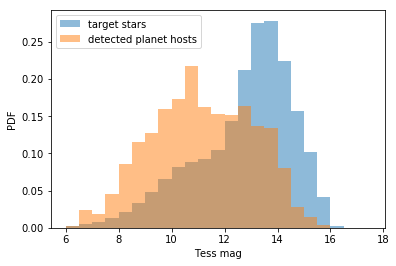

In [21]:
q = plt.hist(newDF.TESSMAG, bins=np.arange(6,18,0.5), normed=True, alpha=0.5, 
             label='target stars')
q = plt.hist(detected_DF.TESSMAG, bins=np.arange(6,18,0.5), normed=True, alpha=0.5,
            label='detected planet hosts')
plt.legend()
plt.xlabel('Tess mag')
plt.ylabel('PDF')
plt.savefig('starmagdist.png', dpi=150)

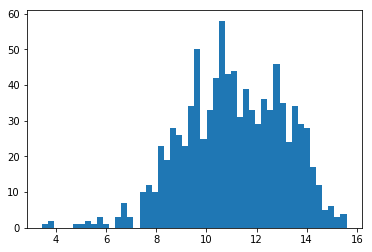

In [22]:
q = plt.hist(detected_DF.TESSMAG, bins=50) 

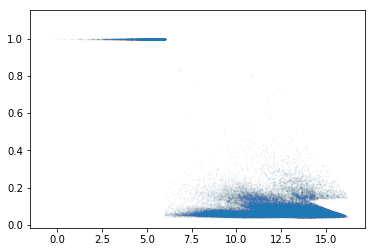

In [23]:
plt.scatter(newDF.TESSMAG, newDF.PRIORITY, s=1, alpha=0.01)

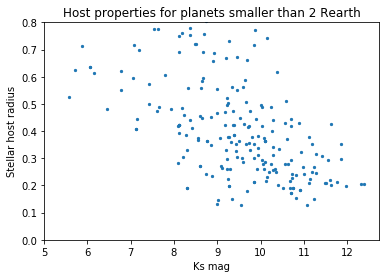

In [24]:
plt.scatter(detected_DF.Ks[detected_DF.planetRadius < 2.0], detected_DF.RADIUS[detected_DF.planetRadius < 2.0], s=5)
plt.ylim(0,0.8)
plt.xlabel('Ks mag')
plt.ylabel('Stellar host radius')
plt.title('Host properties for planets smaller than 2 Rearth')
plt.savefig('hosts.png', dpi=150)

In [25]:
detected_DF.loc[(detected_DF.planetRadius < 4.0) & (detected_DF.TESSMAG < 12.0)]

,Unnamed: 0,RA,DEC,ECLONG,ECLAT,Ks,TESSMAG,TEFF,RADIUS,MASS,...,omega,rprs,impact,duration,duration_correction,transit_depth,transit_depth_diluted,needed_for_detection,has_transits,detected
3341,203357,181.386760,-43.727394,201.940081,-38.846250,8.191000,9.545000,5280.0000,0.760671,0.905791,...,0.210706,0.019728,0.132487,0.080804,1.392589,389.212758,373.696026,246.950125,True,True
3514,204135,144.074312,-78.344933,239.777598,-71.034470,7.160000,8.022000,6767.0000,1.045170,1.449315,...,-2.337744,0.010852,0.080226,0.112302,1.641723,117.761042,117.543017,98.909441,True,True
3515,204135,144.074312,-78.344933,239.777598,-71.034470,7.160000,8.022000,6767.0000,1.045170,1.449315,...,2.038985,0.028830,0.298160,0.174828,2.048380,831.142514,829.603722,403.198562,True,True
3538,204200,97.111921,-49.167618,105.379200,-72.227374,7.341000,8.241000,5856.0000,1.698060,1.058050,...,1.512320,0.010567,0.131654,0.199374,2.187458,111.670670,111.544619,153.170524,True,True
3617,204564,208.973873,-31.608103,218.232267,-18.466812,7.552000,8.264000,6544.0000,1.430530,1.352032,...,2.616444,0.020456,0.430124,0.206013,2.223583,418.464890,414.329381,218.593323,True,True
3676,204833,10.503828,-53.198948,339.662656,-51.085664,7.410000,8.255000,5879.0000,1.128460,1.065082,...,-2.532759,0.028455,0.406124,0.168524,2.011116,809.710762,809.709205,546.410365,True,True
4325,205667,210.105218,-36.021252,220.901846,-22.221331,6.989000,7.703000,6416.4600,1.578710,1.291771,...,-0.779185,0.011143,0.175240,0.154145,1.923403,124.163794,123.933400,103.260891,True,True
4686,207191,67.643363,-71.691078,317.087219,-80.610210,8.690000,9.591000,5414.1001,1.436190,1.197221,...,2.721414,0.012329,0.987475,0.029354,0.839348,152.005338,151.061821,221.752150,True,True
4748,207946,86.185681,-55.836128,78.580625,-79.124125,9.219000,10.146000,5791.5000,1.222050,1.157251,...,-0.757054,0.011604,0.070946,0.139883,1.832263,134.653306,134.324619,323.380924,True,True
4819,210362,3.988231,-79.066185,296.563752,-64.968392,9.846000,10.720000,6249.7998,0.956037,1.037365,...,-1.148858,0.017044,0.155543,0.111262,1.634102,290.485526,284.429814,298.636391,True,True


In [26]:
7.3 / np.sqrt(3)

4.2146569650842682

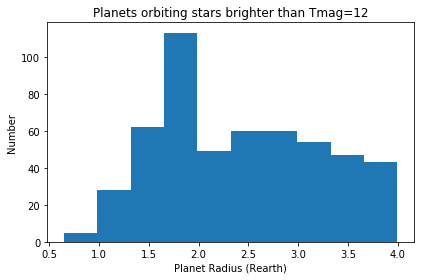

In [27]:
plt.hist(detected_DF.loc[(detected_DF.planetRadius < 4.0) & (detected_DF.TESSMAG < 12.0), 'planetRadius'])
plt.xlabel('Planet Radius (Rearth)')
plt.ylabel('Number')
plt.title('Planets orbiting stars brighter than Tmag=12')
plt.tight_layout()
plt.savefig('brightdetected.png', dpi=150)

In [28]:
detected_DF.loc[(detected_DF.TESSMAG < 14.0) & 
                (detected_DF.RADIUS < 0.5) & (detected_DF.planetRadius < 2.0)]

,Unnamed: 0,RA,DEC,ECLONG,ECLAT,Ks,TESSMAG,TEFF,RADIUS,MASS,...,omega,rprs,impact,duration,duration_correction,transit_depth,transit_depth_diluted,needed_for_detection,has_transits,detected
8665,264507,92.174105,-53.023190,95.577003,-76.420389,9.217,11.313,3709.0,0.497000,0.534000,...,2.443049,0.032724,0.745368,0.062202,1.221825,1070.873506,1056.536778,952.291216,True,True
19190,629903,196.011102,-18.771540,201.995071,-11.032227,9.768,12.074,3389.0,0.330000,0.330000,...,-2.476821,0.038359,0.080564,0.050375,1.099550,1471.384233,1448.985076,723.856627,True,True
22075,693180,328.350916,-81.135941,285.682678,-60.969624,10.728,13.409,3086.0,0.240955,0.217360,...,-0.216128,0.066539,0.021453,0.067258,1.270512,4427.402069,4424.652581,1886.300224,True,True
30194,1012759,305.591718,-37.046444,299.084230,-17.132019,10.684,13.239,3082.0,0.192000,0.161000,...,-2.761933,0.085330,0.683767,0.024579,0.768041,7281.164929,7277.247516,3591.204263,True,True
33301,1119330,143.323235,-72.284317,221.001144,-71.132917,10.231,12.315,3690.0,0.487000,0.522000,...,1.114044,0.023614,0.666420,0.028774,0.831009,557.603976,540.495974,780.707654,True,True
38713,1245215,340.881761,-46.519028,322.693773,-35.175343,8.650,10.800,3615.0,0.448000,0.475000,...,-1.777173,0.037293,0.946546,0.036159,0.931562,1390.749617,1384.018765,353.232757,True,True
39351,1246165,183.921203,-18.910139,191.281101,-15.759996,9.860,12.191,3331.0,0.301000,0.294000,...,-2.624633,0.056154,0.311477,0.070731,1.302894,3153.250711,3143.082824,971.633915,True,True
45376,1556627,332.820744,41.015167,355.301316,47.663404,7.435,9.452,3787.0,0.499000,0.556000,...,-1.931310,0.030601,0.832079,0.039597,0.974845,936.436199,905.613149,382.433217,True,True
50748,1621589,28.230619,-63.491711,337.577949,-64.824184,9.261,12.216,2977.0,0.197454,0.171601,...,-0.072270,0.068190,0.134127,0.033393,0.895229,4649.852367,4474.822547,3199.827651,True,True
50751,1621589,28.230619,-63.491711,337.577949,-64.824184,9.261,12.216,2977.0,0.197454,0.171601,...,1.205834,0.050816,0.275345,0.043748,1.024673,2582.222908,2485.022831,1257.664162,True,True


In [29]:
detected_DF.loc[(detected_DF.TESSMAG > 14.0) & 
                (detected_DF.RADIUS < 0.5) & (detected_DF.planetRadius < 2.0)]

,Unnamed: 0,RA,DEC,ECLONG,ECLAT,Ks,TESSMAG,TEFF,RADIUS,MASS,...,omega,rprs,impact,duration,duration_correction,transit_depth,transit_depth_diluted,needed_for_detection,has_transits,detected
8546,261541,71.465015,-59.931156,29.905202,-79.412508,11.866,14.423,3306.0,0.352524,0.341381,...,-3.130278,0.049765,0.254554,0.048312,1.076793,2476.519511,2287.223307,4601.236659,True,True
21579,692085,300.070388,-1.788958,301.854387,18.386815,11.241,14.058,2944.0,0.151000,0.115000,...,-3.125966,0.120313,0.935078,0.027355,0.810258,14475.106510,11908.287324,2955.525033,True,True
55162,1777755,265.878265,53.285538,259.336673,76.572225,11.599,14.177,3151.0,0.219000,0.193000,...,0.646284,0.073264,0.966300,0.011419,0.523506,5367.564341,3720.785471,4743.257502,True,True
120113,3847044,77.895480,-74.363930,291.805175,-81.248131,11.626,14.237,3110.0,0.203000,0.174000,...,-1.509535,0.084002,0.613196,0.040384,0.984488,7056.364630,6430.013598,7756.118200,True,True
120128,3847055,63.525610,-65.414864,353.835793,-79.248458,11.496,14.083,3127.0,0.209000,0.181000,...,-1.105860,0.085991,0.136967,0.056415,1.163595,7394.449643,5081.471425,5952.031835,True,True
150327,4932002,185.984730,-27.963017,197.145723,-23.177266,11.069,14.287,2804.0,0.127000,0.095000,...,-2.927229,0.108048,0.035469,0.040139,0.981495,11674.435675,11505.644749,3459.086433,True,True
161344,5355471,100.065161,-57.867596,122.910042,-80.148979,11.760,14.352,3139.0,0.214000,0.187000,...,-0.472147,0.084789,0.125093,0.063831,1.237713,7189.182741,6991.062571,7012.525847,True,True
211207,6862969,271.566732,63.728420,283.802558,87.092390,11.866,14.363,3323.0,0.297000,0.288000,...,-1.207500,0.060345,0.767521,0.032199,0.879079,3641.565206,3583.131247,5105.424408,True,True
228175,7360464,273.683139,52.928879,279.375182,76.248288,11.517,14.155,3128.0,0.210000,0.182000,...,-1.379726,0.073374,0.029453,0.060872,1.208686,5383.785964,5164.150527,4100.655340,True,True
228895,7381236,254.266116,66.654396,171.918692,83.769072,12.381,14.975,3117.0,0.205000,0.177000,...,-1.338634,0.050776,0.253307,0.022731,0.738613,2578.216249,2488.313536,6329.326741,True,True


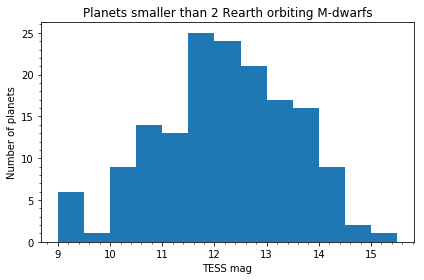

In [30]:
plt.hist(detected_DF.loc[(detected_DF.RADIUS < 0.5) & 
                         (detected_DF.planetRadius < 2.0), 'TESSMAG'],
        bins=np.arange(9,16,0.5))
plt.xlabel('TESS mag')
plt.ylabel('Number of planets')
plt.title('Planets smaller than 2 Rearth orbiting M-dwarfs')
plt.minorticks_on()
plt.tight_layout()

plt.savefig('smallplanets_smallstars.png', dpi=150)

/Users/tom/anaconda3/lib/python3.6/site-packages/matplotlib/projections/geo.py:590: RuntimeWarning: invalid value encountered in arcsin
  c = 2.0 * np.arcsin(0.5 * p)


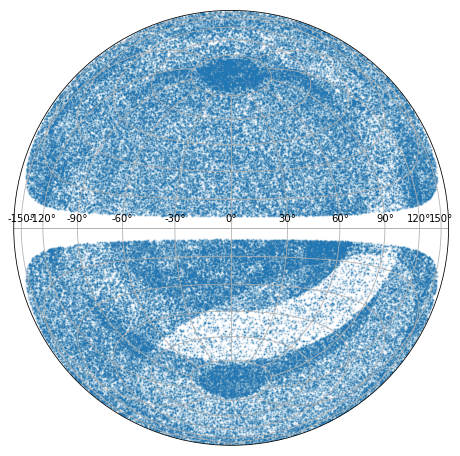

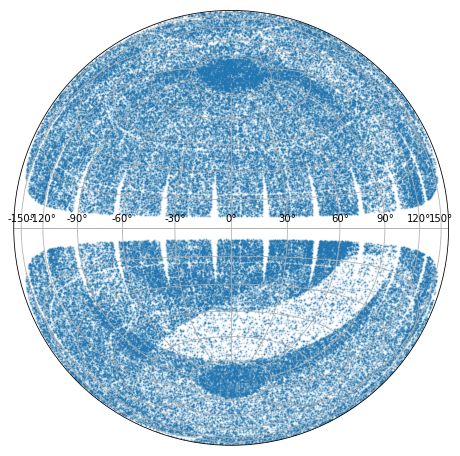

In [31]:
plt.figure(figsize=[8,8])
plt.subplot(111, projection='lambert')
plt.scatter(np.radians(newDF.ECLONG-180), np.radians(newDF.ECLAT), s=1, alpha=0.1)
plt.grid()

plt.figure(figsize=[8,8])
plt.subplot(111, projection='lambert')
plt.scatter(np.radians(newDF[newDF.tess_ccd > 0].ECLONG-180), np.radians(newDF[newDF.tess_ccd > 0].ECLAT), s=1, alpha=0.1)
plt.grid()

/Users/tom/anaconda3/lib/python3.6/site-packages/matplotlib/projections/geo.py:590: RuntimeWarning: invalid value encountered in arcsin
  c = 2.0 * np.arcsin(0.5 * p)


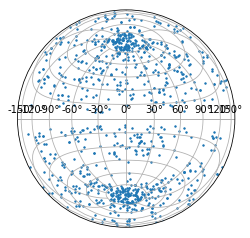

In [32]:
plt.figure()
plt.subplot(111, projection='lambert')
plt.scatter(np.radians(detected_DF.ECLONG-180), np.radians(detected_DF.ECLAT), s=2, alpha=1)
plt.grid()

In [87]:
from mpl_toolkits.basemap import Basemap
m = Basemap(projection='ortho',lon_0=0,lat_0=60,resolution='h')
m.scatter(detected_DF.ECLONG.values, detected_DF.ECLAT.values, s=12, alpha=1, latlon=True, zorder=100)
m.scatter(newDF[newDF.tess_ccd > 0].ECLONG.values, newDF[newDF.tess_ccd > 0].ECLAT.values, 
          s=1, alpha=0.1, latlon=True)
parallels = [-78. -54, -30, -6, 6, 30, 54, 78, ]
m.drawparallels(parallels, latmax=78, )
meridians = np.linspace(240-12,360+240-12,14)[:-1]
m.drawmeridians(meridians,)
# m.drawcoastlines()
# m = Basemap(projection='hammer',lon_0=180)
# m.drawmapboundary(fill_color='#99ffff')
# q = m.fillcontinents(color='#cc9966',lake_color='#99ffff')
# m.scatter(np.arange(0,360,1), np.arange(0,360,1),3,marker='o',color='k', latlon=True)

IndexError: index -1 is out of bounds for axis 0 with size 0

In [31]:
F = +4.73508403525e-5
E = -0.0022308015894
D = +0.0395908321369
C = -0.285041632435
B = +0.850021465753
lnA = +3.29685004771

In [32]:
T = np.arange(0,18,0.01)
lnN = lnA + B*T + C*T**2 + D*T**3 + E*T**4 + F*T**5

(7, 17)

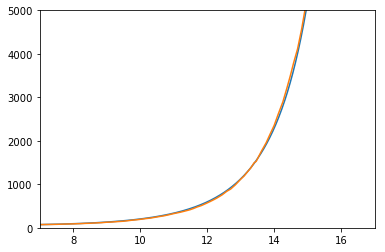

In [33]:
plt.plot(T,np.exp(lnN))
plt.plot(mag_level, noise_level)
plt.ylim(0,5000)
plt.xlim(7,17)

(0, 2)

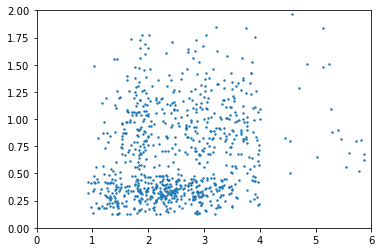

In [34]:
plt.scatter(detected_DF.planetRadius, detected_DF.RADIUS, s=2)
plt.xlim(0,6)
plt.ylim(0,2)

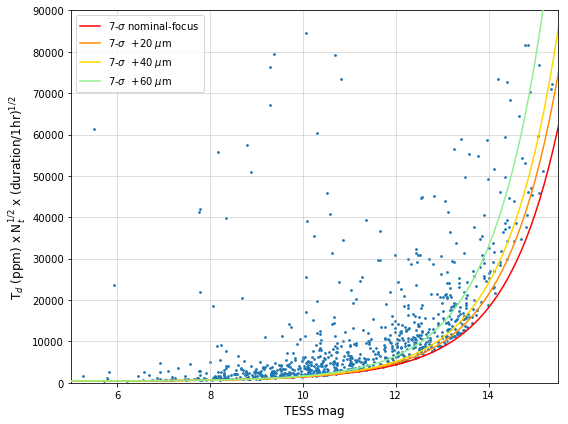

In [35]:
x = np.arange(0,20,0.1)
fig, ax = plt.subplots(1,1, figsize=[8,6])
# plt.scatter(detected_DF.TESSMAG, detected_DF.transit_depth_diluted * np.sqrt(detected_DF.Ntransits) * detected_DF.duration_correction,  
#             s=1, alpha=1)
# plt.plot(x, component_noise(x) * 7, zorder=100, color='gold', label='4-$\sigma$ good-focus')
# plt.plot(x, component_noise(x, readmod=np.sqrt(1.5), zodimod=np.sqrt(1.5)) * 7, 
#          zorder=100, color='darkorange', label='4-$\sigma$  medium-focus')
# plt.plot(x, component_noise(x, readmod=np.sqrt(2), zodimod=np.sqrt(2)) * 7, 
#          zorder=100, color='r', label='4-$\sigma$  bad-focus')

plt.scatter(detected_DF.TESSMAG, detected_DF.transit_depth_diluted * np.sqrt(detected_DF.Ntransits) * detected_DF.duration_correction,  
            s=3, alpha=1)
plt.plot(x, component_noise(x) * 7., zorder=100, label='7-$\sigma$ nominal-focus', color='red')
plt.plot(x, component_noise(x, readmod=np.sqrt(1.5), zodimod=np.sqrt(1.5)) * 7, 
         zorder=100, label='7-$\sigma$  +20 $\mu$m', color='darkorange')
plt.plot(x, component_noise(x, readmod=np.sqrt(2), zodimod=np.sqrt(2)) * 7, 
         zorder=100, label='7-$\sigma$  +40 $\mu$m', color='gold')
plt.plot(x, component_noise(x, readmod=np.sqrt(4), zodimod=np.sqrt(4)) * 7, 
         zorder=100, label='7-$\sigma$  +60 $\mu$m', color='lightgreen')

plt.ylim(0,90000)
plt.xlim(5,15.5)
plt.xlabel('TESS mag', fontsize=12)
plt.ylabel('T$_d$ (ppm) x N$_t^{1/2}$ x (duration/1hr)$^{1/2}$', fontsize=12)
plt.legend()
# ax.set_yscale("log", nonposy='clip')
plt.grid(alpha=0.5)
plt.tight_layout()
# plt.savefig('transitnoise_detected.png', dpi=250)


In [36]:
def get_pixels(tmag):
    c3 = -0.2592
    c2 = 7.7410
    c1 = -77.7918
    c0 = 274.2898
    Npix = c3*tmag**3 + c2*tmag**2 + c1*tmag + c0
    return np.where(Npix < 1.0,1,Npix)

def get_noisemult(Npix, extrapix=0.5):
    return (np.sqrt(Npix) + extrapix)**2 / Npix

In [37]:
dd = detected_DF.transit_depth_diluted * np.sqrt(detected_DF.Ntransits) * detected_DF.duration_correction

In [38]:
noisemult0p5 = get_noisemult(get_pixels(detected_DF.TESSMAG), extrapix=0.5)
noisemult1 = get_noisemult(get_pixels(detected_DF.TESSMAG), extrapix=1)
notdetected_DF = detected_DF[
    component_noise(detected_DF.TESSMAG, 
                    readmod=np.sqrt(noisemult0p5), 
                    zodimod=np.sqrt(noisemult0p5)) * 7 > dd ]


maybedetected_DF = detected_DF[
    (component_noise(detected_DF.TESSMAG, 
                     readmod=np.sqrt(noisemult1), 
                     zodimod=np.sqrt(noisemult1)) * 7 > dd) 
    & (component_noise(detected_DF.TESSMAG, 
                       readmod=np.sqrt(noisemult0p5), 
                       zodimod=np.sqrt(noisemult0p5)) * 7 < dd)]
stilldetected_DF = detected_DF[
    component_noise(detected_DF.TESSMAG, 
                    readmod=np.sqrt(noisemult1), 
                    zodimod=np.sqrt(noisemult1)) * 7 < dd ]

# superbad_DF = detected_DF[
#     component_noise(detected_DF.TESSMAG, 
#                     readmod=np.sqrt(2*2), 
#                     zodimod=np.sqrt(2*2)) * 7 < dd ]


In [39]:
print(notdetected_DF.shape[0])
print(maybedetected_DF.shape[0])
print(stilldetected_DF.shape[0])
# print(superbad_DF.shape[0])
print()
print(notdetected_DF.shape[0] / detected_DF.shape[0])
print(maybedetected_DF.shape[0] / detected_DF.shape[0])
print(stilldetected_DF.shape[0] / detected_DF.shape[0])
# print(superbad_DF.shape[0] / detected_DF.shape[0])

80
69
742

0.08978675645342311
0.07744107744107744
0.8327721661054994


In [40]:
noisemult0p5 = get_noisemult(get_pixels(detected_DF.TESSMAG), extrapix=0.5)
noisemult1 = get_noisemult(get_pixels(detected_DF.TESSMAG), extrapix=1)
notdetected_DF = detected_DF[
    component_noise(detected_DF.TESSMAG, 
                    readmod=np.sqrt(noisemult0p5), 
                    zodimod=np.sqrt(noisemult0p5)) * 10 > dd ]


maybedetected_DF = detected_DF[
    (component_noise(detected_DF.TESSMAG, 
                     readmod=np.sqrt(noisemult1), 
                     zodimod=np.sqrt(noisemult1)) * 10 > dd) 
    & (component_noise(detected_DF.TESSMAG, 
                       readmod=np.sqrt(noisemult0p5), 
                       zodimod=np.sqrt(noisemult0p5)) * 10 < dd)]
stilldetected_DF = detected_DF[
    component_noise(detected_DF.TESSMAG, 
                    readmod=np.sqrt(noisemult1), 
                    zodimod=np.sqrt(noisemult1)) * 10 < dd ]

# superbad_DF = detected_DF[
#     component_noise(detected_DF.TESSMAG, 
#                     readmod=np.sqrt(2*2), 
#                     zodimod=np.sqrt(2*2)) * 7 < dd ]


In [41]:
print(notdetected_DF.shape[0])
print(maybedetected_DF.shape[0])
print(stilldetected_DF.shape[0])
# print(superbad_DF.shape[0])
print()
print(notdetected_DF.shape[0] / detected_DF.shape[0])
print(maybedetected_DF.shape[0] / detected_DF.shape[0])
print(stilldetected_DF.shape[0] / detected_DF.shape[0])
# print(superbad_DF.shape[0] / detected_DF.shape[0])

314
41
536

0.35241301907968575
0.04601571268237935
0.6015712682379349


In [42]:
from tvguide import TessPointing
obj = TessPointing(detected_DF.RA.iloc[0], detected_DF.DEC.iloc[0])
obj.get_13cameras()[obj.get_13cameras() > 0].shape[0]

In [64]:
df.ix[df.iloc, 'tess_ccd']

/Users/tom/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  if __name__ == '__main__':


2

In [70]:
6+24

30